# Семинар 6. Поговорим про SSL (Self-Supervised Learning)!

![ssssl](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Self-Supervised-Learning-and-Its-Applications_16.png?resize=593%2C343&ssl=1)

## Self-Supervised Learning в Computer Vision

**Supervised learning** требует меток
Классический подход к обучению computer vision моделей:

```
Датасет ImageNet:
    - 1.2 миллиона изображений
    - Каждое изображение вручную размечено
    - 1000 классов объектов
    
Процесс создания:
    - Наняли тысячи людей на Amazon Mechanical Turk
    - Каждое изображение проверялось несколькими людьми
    - Стоимость: миллионы долларов
    - Время: годы работы
```

Это создаёт фундаментальное ограничение: мы можем обучать модели только на тех данных, которые смогли разметить. А разметка дорогая и медленная.

---

### **Scale** проблема

```
Размеченные данные (supervised):
    ImageNet: 1.2M изображений
    COCO: 330K изображений
    
Неразмеченные данные в интернете:
    Instagram: 95M фото каждый день
    Flickr: 25B+ фотографий всего
    YouTube: 720,000 часов видео каждый день
    
Соотношение: 1,000,000 : 1,000,000,000,000+
```

Мы выбрасываем 99.9999% потенциально полезных данных просто потому что у них нет меток.

---

Ограничения supervised подхода

Узкая специализация:

* Модель обученная на ImageNet хорошо различает 1000 классов объектов, но:

    * Не понимает текстуры и материалы
    * Не различает стили и композицию
    * Не понимает пространственные отношения между объектами
    * Плохо переносится на новые задачи

Bias в данных:

* ImageNet собран определённым образом:

    * Центрированные объекты
    * Хорошее освещение
    * Чистые фоны
    * Западная культурная перспектива

* Модель учится этим артефактам датасета, а не общему пониманию визуального мира.

Дороговизна адаптации.

* Хотите добавить новую задачу? Нужно:

    * Собрать новый датасет
    * Разметить тысячи примеров
    * Переобучить модель
    * Повторить для каждой новой задачи

## Self-Supervised Learning - концепция

![ssl](https://images.prismic.io/encord/b1ec1b83-939b-403a-9b78-6aa2f92d0848_Self-supervised+learning+%28SSL%29+workflow.png?auto=compress,format)


### Основная идея

Self-supervised learning переворачивает парадигму: вместо того чтобы учить модель конкретной задаче с метками, мы учим её понимать структуру визуального мира через задачи, которые не требуют ручной разметки.


### Ключевой инсайт:

Визуальные данные сами содержат сигнал для обучения. Нам не нужен человек, чтобы сказать "это кошка" - мы можем создать задачу, решение которой требует понимания изображения.


---

**Pretext** задачи

Pretext задача - это искусственная задача, которую мы создаём автоматически, без человека. Решение этой задачи заставляет модель выучить полезные представления.

Ранние примеры.


**Rotation prediction**:

```
Берём изображение
Поворачиваем на 0°, 90°, 180° или 270°
Модель должна предсказать угол поворота

Чтобы решить это:
    - Модель должна понимать что такое "верх" и "низ"
    - Различать объекты и их естественную ориентацию
    - Понимать гравитацию и физику мира
```

**Jigsaw puzzle:**

```
Разрезаем изображение на 9 частей
Перемешиваем их
Модель должна предсказать правильный порядок

Чтобы решить это:
    - Модель должна понимать границы объектов
    - Различать части одного объекта
    - Понимать пространственные отношения
```

**Colorization:**

```
Берём цветное изображение
Переводим в grayscale
Модель должна предсказать цвета

Чтобы решить это:
    - Модель должна знать что небо обычно синее
    - Трава зелёная
    - Кожа человека определённых оттенков
```

Эти задачи работали, но были ограничены: они полагались на конкретные инвариантности (вращение, позиция, цвет), которые не покрывают всё богатство визуального мира.

## Contrastive Learning (тот же самый, что мы с Вами обсуждали в CLIP)

Принцип — разные view одного изображения должны иметь похожие представления. View разных изображений должны иметь различные представления.

Это гораздо более общий принцип, который не полагается на конкретные инвариантности.

### SimCLR - простой contrastive метод


Алгоритм
```
1. Берём изображение
2. Применяем две случайные аугментации:
   - Random crop
   - Color jitter
   - Gaussian blur
   - Horizontal flip
   
   Получаем два view: x_i и x_j

3. Пропускаем через encoder:
   z_i = f(x_i)
   z_j = f(x_j)

4. Contrastive loss:
   - Максимизировать similarity(z_i, z_j)
   - Минимизировать similarity(z_i, z_k) для всех k != i
```

Почему это работает:

Чтобы правильно определить что два сильно аугментированных view это одно и то же изображение, модель должна:

* Игнорировать низкоуровневые детали (цвет, позицию)
* Фокусироваться на высокоуровневой семантике (что изображено)
* Понимать инвариантности реального мира

Проблема SimCLR:

Требует огромные batch size (4096-8192) чтобы иметь достаточно негативных примеров. Это требует много GPU памяти.

---

### MoCo - momentum contrastive learning

MoCo решил проблему *batch size* через умный трюк: очередь негативных примеров.

Ключевые идеи:

**Momentum encoder:**

```
Два энкодера:
    - Query encoder (обучаемый)
    - Key encoder (momentum update)

Key encoder обновляется медленно:
    θ_key = m × θ_key + (1-m) × θ_query
    где m = 0.999 (очень медленное обновление)
```

Возможные вопросы.

1. Что делать, если поменять `m`?

    * Если `m=0.5` — key encoder будет меняться быстро, очередь станет неконсистентной, обучение может стать неустойчивым.
    * Если `m=0` — key encoder будет копировать query encoder на каждом шаге (= один энкодер). Модель начнёт читерить.
2. Зачем очередь? Почему не увеличить batch size?
    * Потому что `batch size` упрётся в память GPU. Очередь хранит эмбеддинги, а не картинки — они маленькие (например, 128 чисел). Можно иметь 65К негативов в очереди при батче 256


**Queue of negatives:**

```
Храним очередь из последних N key embeddings
Можем использовать 65536 негативов не увеличивая batch size
Очередь постоянно обновляется - старые выбрасываются, новые добавляются
```

Это позволило обучать contrastive модели эффективно даже на небольших batch size.


И по сути, MoCo — это умный костыль, чтобы обойти ограничение памяти GPU. Вместо того, чтобы грузить 65К картинок в батч, мы храним 65К векторов в очереди и медленно обновляем энкодер, который их создаёт.

## Часть 3: DINO - революция в self-supervised learning

От contrastive к knowledge distillation.

DINO (Self-Distillation with No Labels, Facebook AI, 2021) представил принципиально новый подход к self-supervised learning.


Ключевое отличие от contrastive:
* Contrastive методы (SimCLR, MoCo):

    * Требуют негативные примеры
    * Требуют большие batch size или очереди
    * Сложная балансировка положительных и отрицательных пар

* DINO:

    * Не требует негативные примеры
    * Работает с любым batch size
    * Основан на knowledge distillation между teacher и student

### Архитектура DINO

Student-Teacher framework:

![dino](https://miro.medium.com/v2/resize:fit:858/1*HZaFSh3dQIy-Zw3jfeCjvg.png)

Ссылочка: https://github.com/facebookresearch/dino


```
Одно изображение → два типа аугментаций:

Global views (224×224):
    - Большие crops, покрывают 50%+ изображения
    - Два независимых global view
    
Local views (96×96):
    - Маленькие crops, покрывают <50% изображения
    - Несколько местных view (обычно 6-8)
```

Два энкодера:

```
Student network:
    - Видит ВСЕ views: global + local
    - Обрабатывает каждый view отдельно
    - Для каждого view выдаёт embedding

Teacher network:
    - Видит только global views
    - НЕ обучается через backprop
    - Обновляется через exponential moving average (EMA) student весов
    - θ_teacher = m × θ_teacher + (1-m) × θ_student
```


![dino_gif](https://github.com/facebookresearch/dino/raw/main/.github/dino.gif)

Механизм обучения:

```
1. Student обрабатывает все views:
   - Global view 1 → student → output_s1
   - Global view 2 → student → output_s2
   - Local view 1 → student → output_s3
   - Local view 2 → student → output_s4
   ...

2. Teacher обрабатывает только global views:
   - Global view 1 → teacher → output_t1
   - Global view 2 → teacher → output_t2

3. Loss: student должен предсказать teacher outputs
   - Match student(global_1) с teacher(global_2)
   - Match student(global_2) с teacher(global_1)
   - Match student(local_1) с teacher(global_1 или global_2)
   - Match student(local_2) с teacher(global_1 или global_2)
   ...
```

А как выглядит лосс?

```python
import torch
import torch.nn.functional as F

# Teacher output (target distribution)
teacher_output = torch.randn(1, 65536)
teacher_probs = F.softmax(teacher_output / 0.04, dim=-1)  # temperature

# Student output (prediction distribution)
student_output = torch.randn(1, 65536)
student_log_probs = F.log_softmax(student_output / 0.1, dim=-1)

# Manual cross-entropy
loss = -torch.sum(teacher_probs * student_log_probs, dim=-1).mean()
```


И почему это работает?

Teacher видит только большие, информативные части изображения. Student должен научиться предсказывать эти же представления даже видя только маленькие local crops.

Это заставляет student:

* Понимать структуру объектов
* Различать важные и неважные детали
* Строить целостное представление из частичной информации

---

Что выучивает DINO?

DINO показал удивительные emergent свойства, которые не были явно запрограммированы:

* Attention maps:
    * Когда визуализируем attention головки последнего слоя ViT обученного с DINO, они автоматически выучивают:

      * Segmentation объектов
      * Boundaries между объектами и фоном
      * Части объектов (голова, тело, лапы животного)

    * Это происходит без единой метки segmentation.


* Semantic correspondence:
    * DINO представления позволяют находить соответствия между разными изображениями одного класса:

        * Голова собаки на одном фото соответствует голове на другом
        * Колесо машины соответствует колесу другой машины

* Robustness:
    * DINO гораздо более robust к аугментациям и изменениям в изображении чем supervised модели. Это происходит потому что модель обучалась сопоставлять сильно отличающиеся views.

![segm](https://github.com/facebookresearch/dino/raw/main/.github/attention_maps.png)

📦 Загружаем DINO...


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Patch features: (196, 384)


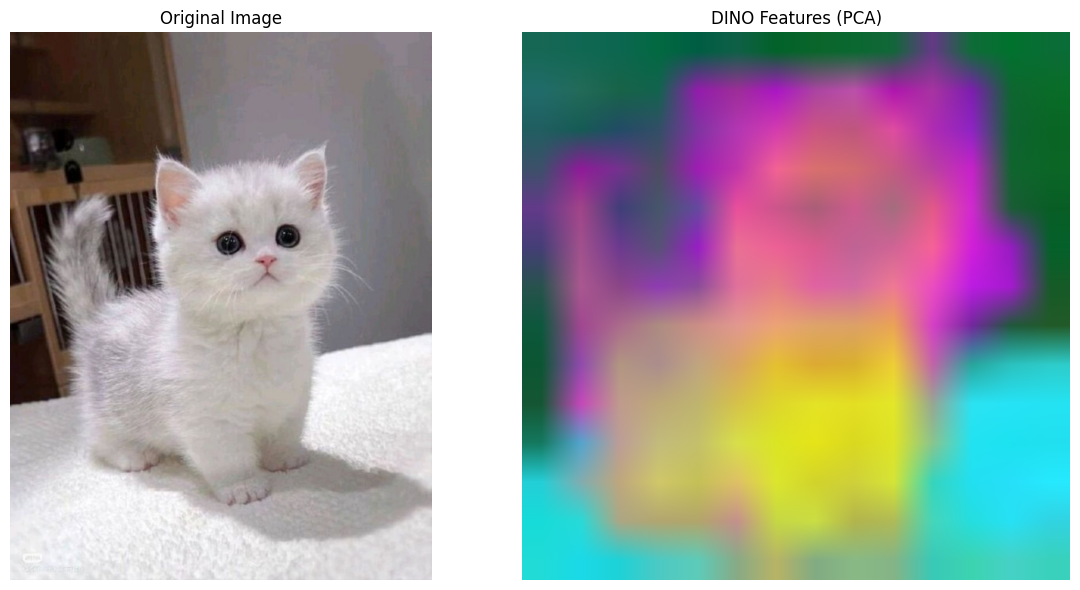

✅ Saved: dino_features.png


In [9]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# ========== 1. Загрузка модели ==========

print("📦 Загружаем DINO...")
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
model.eval()

# ========== 2. Подготовка изображения ==========

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img = Image.open("/content/976e3ddff4cf700b1449f262cf15865f.jpg").convert('RGB')
img_tensor = transform(img).unsqueeze(0)

# ========== 3. Извлекаем patch features ==========

with torch.no_grad():
    # Get all tokens (CLS + patches)
    features = model.get_intermediate_layers(img_tensor, n=1)[0]
    # Shape: [1, num_patches+1, dim]

    # Берём только patch tokens (без CLS)
    patch_features = features[0, 1:, :].cpu().numpy()
    # Shape: [196, 384] для ViT-S/16

print(f"Patch features: {patch_features.shape}")

# ========== 4. PCA для визуализации ==========

# Применяем PCA для сжатия 384 dim → 3 dim (RGB)
pca = PCA(n_components=3)
pca_features = pca.fit_transform(patch_features)

# Нормализуем в [0, 1]
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())

# Reshape в сетку 14×14
h_patches = w_patches = int(np.sqrt(patch_features.shape[0]))
pca_image = pca_features.reshape(h_patches, w_patches, 3)

# ========== 5. Визуализация ==========

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Оригинал
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# PCA features
axes[1].imshow(pca_image, interpolation='bilinear')
axes[1].set_title("DINO Features (PCA)")
axes[1].axis('off')

plt.tight_layout()
plt.savefig('dino_features.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: dino_features.png")


### MaskedMAE

![maskedmae](https://user-images.githubusercontent.com/11435359/146857310-f258c86c-fde6-48e8-9cee-badd2b21bd2c.png)

Давайте заставим модельку учить семантику. Но как?

```
Изображение → разбить на patches
Маскировать 75% patches (!!!)
Модель восстанавливает замаскированные части
```

Изображения имеют огромную spatial redundancy. Видя 25% patches, часто можно угадать остальное по текстуре и паттернам. Чтобы заставить модель учить семантику, нужно маскировать агрессивно.

![recon](https://miro.medium.com/v2/resize:fit:896/format:webp/1*tdMp6QlzP4V9iPTOKetuIg.png)

---

Почему MAE работает
* Information bottleneck:
Модель видит только 25% изображения. Чтобы восстановить остальное, нужно:

    * Понимать объекты (голова кошки → есть тело)
    * Знать текстуры (трава зелёная)
    * Понимать сцены (небо сверху, земля снизу)

* Вынужденное обобщение:
    * Нельзя просто копировать соседние patches (их может не быть). Нужно понимать высокоуровневую структуру.
* Эффективность:
    * Encoder обрабатывает только 25% → обучение в 3-4× быстрее чем обычный ViT


НО! MAE требует fine-tuning для хороших результатов. DINO/DINOv2/DINOv3 можно использовать frozen.

## I-JEPA (Image-based Joint-Embedding Predictive Architecture)

![ijepa_arch](https://images.prismic.io/encord/64b9cc18-dcb9-4fd1-95c4-c5f34f4f0877_image8.png?auto=compress,format)

Идея в одном предложении: «Учим модель понимать высокоуровневые представления о мире, заставляя её предсказывать, как выглядит одна часть изображения для другой, но в пространстве сжатых „идей“ (эмбеддингов), а не пикселей».

### Ключевые отличия от MAE и DINO:

1. Не пиксели, а представления. Цель — предсказать не недостающие пиксели (как в MAE), а векторы-эмбеддинги скрытых патчей.

2. Контекстуальное, а не локальное. Нужно использовать информацию из видимой области (context), чтобы предсказать представления невидимой целевой области (target), которые находятся на расстоянии от неё. Это заставляет модель учиться о геометрии и отношениях между частями объекта/сцены.

3. Учитель без ярлыков. Как и в DINO, есть студент и учитель. Но задача студента — не глобальная классификация, а регрессия представлений учителя для целевой области.


![ijepa](https://images.prismic.io/encord/b82facf4-92a7-44ca-9636-5e7cd8bd8f53_image7.png?auto=compress,format)

1. Слева (Original): Оригинальная фотография.

2. По центру (Context): Часть изображения, которую видит контекстный энкодер (студент). Это случайный набор видимых блоков.

3. Справа (Targets): Часть изображения, которую модель должна предсказать. Это четыре больших, семантически цельных области, которые были скрыты от студента.

### Задача

Научить модель, глядя на разрозненные видимые куски (Context), построить в голове целостную модель сцены и предсказать, как выглядят крупные скрытые области (Targets) — но не в пикселях, а в виде их сущностных, сжатых представлений ("идей").

Если step-by-step, то:
* Берём изображение. Маскируем большие блоки.
    * Context: видим голову собаки (пример)
    * Target: замаскированная часть тела
* Context Encoder обрабатывает видимое:
    * Context Patches (голова собаки) -> Context Encoder -> z_context
    * z_context = представление того, что видим
* Target Encoder обрабатываем замаскированное
    * Target patches (тело собаки) -> Target Encoder -> z_target
    * z_target = "правильное" представление того, что спрятано
    * Target Encoder = EMA Teacher (как в DINO)
* Predictor предсказывает:
    * Predictor смотрит на z_context. Пытается предсказать: какой будет z_target?
* $\text{Loss} = \|\text{predicted}_z - z_{\text{target}}\|^2$
    * Минимизируем расстояние между предсказанным и реальным представлением

# Домашка

Self-Supervised Learning: DINO v2 Fine-tuning

Сравниваем три подхода к обучению классификатора:
1. From Scratch — ResNet-18 с нуля
2. Linear Probe — замороженный DINO v2 + линейный классификатор  
3. Fine-tuning — дообучение DINO v2

Датасет: Oxford-IIIT Pets (37 пород кошек и собак)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
# ============ Config ============

CONFIG = {
    "batch_size": 32,
    "num_epochs_scratch": 30,
    "num_epochs_linear": 10,
    "num_epochs_finetune": 10,
    "lr_scratch": 0.001,
    "lr_linear": 0.001,
    "lr_finetune": 1e-5,
    "num_classes": 37,
    "image_size": 224,
    "train_samples": 2000,
    "val_samples": 500,
    "wandb_project": "ssl-dino-pets",  # Измените на свой проект
}

In [4]:
# ============ Dataset ============

class PetsDataset:
    """Обёртка над HuggingFace dataset."""

    def __init__(self, hf_dataset, transform):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        label = item["label"]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
def get_transforms():
    """
    Аугментации и нормализация.

    Вопрос: почему мы используем ImageNet mean/std, а не статистики Oxford Pets?
    """

    transform_train = T.Compose([
        T.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        T.RandomHorizontalFlip(),
        T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
        T.ColorJitter(brightness=0.2, contrast=0.2),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transform_val = T.Compose([
        T.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform_train, transform_val

In [6]:
def load_pets_data():
    """Загрузка Oxford Pets dataset."""

    print("Loading Oxford Pets dataset...")
    dataset = load_dataset("timm/oxford-iiit-pet", trust_remote_code=True)

    train_data = dataset["train"]
    val_data = dataset["test"]

    if CONFIG["train_samples"]:
        indices = np.random.choice(len(train_data), CONFIG["train_samples"], replace=False)
        train_data = train_data.select(indices)

    if CONFIG["val_samples"]:
        indices = np.random.choice(len(val_data), CONFIG["val_samples"], replace=False)
        val_data = val_data.select(indices)

    transform_train, transform_val = get_transforms()

    train_dataset = PetsDataset(train_data, transform_train)
    val_dataset = PetsDataset(val_data, transform_val)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"],
                              shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"],
                            shuffle=False, num_workers=2, pin_memory=True)

    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")

    return train_loader, val_loader



In [8]:
# ============ Models ============

class ResNetFromScratch(nn.Module):
    """
    ResNet-18 обучаемый с нуля (случайная инициализация).
    Это baseline для сравнения с SSL подходами.
    """

    def __init__(self, num_classes):
        super().__init__()
        from torchvision.models import resnet18

        # TODO 1: Загрузите ResNet-18 БЕЗ pretrained весов
        # Подсказка: weights=None
        self.backbone = resnet18(???)

        # TODO 2: Замените последний FC слой
        # ResNet-18 имеет 512 выходных features
        self.backbone.fc = ???

    def forward(self, x):
        return self.backbone(x)


class DINOLinearProbe(nn.Module):
    """
    Замороженный DINO v2 + обучаемый линейный классификатор.

    Linear Probe — стандартный способ оценить качество SSL representations.
    Backbone заморожен, обучается только один линейный слой.
    """

    def __init__(self, backbone, feature_dim, num_classes):
        super().__init__()
        self.backbone = backbone

        # TODO 3: Заморозьте все параметры backbone
        for param in self.backbone.parameters():
            ???

        # TODO 4: Создайте линейный классификатор
        self.classifier = ???

    def forward(self, x):
        # TODO 5: Извлеките features БЕЗ градиентов
        # Подсказка: torch.no_grad() context manager
        with ???:
            features = self.backbone(x)

        return self.classifier(features)


class DINOFinetune(nn.Module):
    """
    DINO v2 с полным fine-tuning.
    И backbone, и classifier обучаются вместе.
    """

    def __init__(self, backbone, feature_dim, num_classes):
        super().__init__()
        self.backbone = backbone

        # TODO 6: Разморозьте backbone
        for param in self.backbone.parameters():
            ???

        self.classifier = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        # TODO 7: Forward pass (градиенты нужны!)
        features = ???
        return self.classifier(features)

In [9]:
def load_dino_backbone():
    """Загрузка DINO v2 ViT-S/14."""

    print("Loading DINO v2 ViT-S/14...")
    backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
    feature_dim = 384

    num_params = sum(p.numel() for p in backbone.parameters()) / 1e6
    print(f"DINO loaded: {num_params:.1f}M parameters, {feature_dim}D features")

    return backbone, feature_dim

In [ ]:
# ============ Training ============

def train_epoch(model, loader, criterion, optimizer):
    """Одна эпоха обучения."""

    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        # TODO 8: Реализуйте training step

        # 8a. Обнулите градиенты
        ???

        # 8b. Forward pass
        outputs = ???

        # 8c. Вычислите loss
        loss = ???

        # 8d. Backward pass
        ???

        # 8e. Optimizer step
        ???

        # Статистика (не изменяйте)
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / total, 100.0 * correct / total


@torch.no_grad()
def evaluate(model, loader):
    """Оценка accuracy."""

    model.eval()
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return 100.0 * correct / total

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, lr, name, run_config):
    """Полный цикл обучения с wandb логированием."""

    # TODO 9: Инициализируйте wandb run
    # Используйте: project, name, config, reinit=True
    wandb.init(
        project=???,
        name=???,
        config={
            **run_config,
            "method": name,
            "num_epochs": num_epochs,
            "lr": lr,
        },
        ???
    )

    criterion = nn.CrossEntropyLoss()

    # TODO 10: Создайте AdamW оптимизатор
    # Важно: передайте только параметры с requires_grad=True!
    optimizer = optim.AdamW(
        ???,
        lr=lr,
        weight_decay=0.01
    )

    # TODO 11: Создайте CosineAnnealingLR scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(???, ???)

    history = {"train_loss": [], "train_acc": [], "val_acc": [], "time": []}

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    # Логируем информацию о модели
    wandb.log({
        "model/trainable_params": trainable,
        "model/total_params": total_params,
        "model/trainable_percent": 100 * trainable / total_params
    })

    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"Trainable params: {trainable:,} / {total_params:,} ({100*trainable/total_params:.1f}%)")
    print(f"{'='*60}")

    start_time = time.time()
    best_val_acc = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_acc = evaluate(model, val_loader)
        current_lr = scheduler.get_last_lr()[0]
        scheduler.step()

        epoch_time = time.time() - epoch_start
        best_val_acc = max(best_val_acc, val_acc)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["time"].append(epoch_time)

        # TODO 12: Логируйте метрики в wandb
        # Залогируйте: train/loss, train/acc, val/acc, val/best_acc, train/lr, epoch
        wandb.log({
            ???
        })

        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Loss: {train_loss:.4f} | "
              f"Train: {train_acc:.1f}% | "
              f"Val: {val_acc:.1f}% | "
              f"Time: {epoch_time:.1f}s")

    total_time = time.time() - start_time

    # Финальные метрики
    wandb.log({
        "final/best_val_acc": best_val_acc,
        "final/total_time": total_time,
    })

    # Summary для сравнения runs в wandb
    wandb.run.summary["best_val_acc"] = best_val_acc
    wandb.run.summary["total_time"] = total_time
    wandb.run.summary["trainable_params"] = trainable

    print(f"\nFinished in {total_time:.1f}s | Best accuracy: {best_val_acc:.1f}%")

    # TODO 13: Завершите wandb run
    ???

    return history

In [ ]:
# ============ Visualization ============

def plot_results(results):
    """Графики сравнения."""

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    colors = {"scratch": "#e74c3c", "linear_probe": "#2ecc71", "finetune": "#3498db"}
    labels = {"scratch": "From Scratch", "linear_probe": "DINO Linear Probe", "finetune": "DINO Fine-tune"}

    ax = axes[0]
    for name, hist in results.items():
        epochs = range(1, len(hist["val_acc"]) + 1)
        ax.plot(epochs, hist["val_acc"], "o-", color=colors[name],
                label=labels[name], linewidth=2, markersize=4)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Accuracy (%)")
    ax.set_title("Convergence: Val Accuracy")
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    for name, hist in results.items():
        epochs = range(1, len(hist["train_loss"]) + 1)
        ax.plot(epochs, hist["train_loss"], "o-", color=colors[name],
                label=labels[name], linewidth=2, markersize=4)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")
    ax.set_title("Training Loss")
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[2]
    names = list(results.keys())
    total_times = [sum(results[n]["time"]) for n in names]
    bars = ax.bar([labels[n] for n in names], total_times, color=[colors[n] for n in names])
    ax.set_ylabel("Total Time (seconds)")
    ax.set_title("Training Time")
    for bar, t in zip(bars, total_times):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f"{t:.0f}s", ha="center", va="bottom", fontsize=10)

    plt.tight_layout()
    plt.savefig("ssl_comparison.png", dpi=150, bbox_inches="tight")
    plt.show()


def print_summary(results):
    """Итоговая таблица."""

    labels = {"scratch": "From Scratch", "linear_probe": "DINO Linear Probe", "finetune": "DINO Fine-tune"}

    print("\n" + "="*70)
    print("RESULTS SUMMARY")
    print("="*70)
    print(f"{'Method':<25} {'Best Acc':>10} {'Epochs':>8} {'Total Time':>12}")
    print("-"*70)

    for name, hist in results.items():
        best_acc = max(hist["val_acc"])
        num_epochs = len(hist["val_acc"])
        total_time = sum(hist["time"])
        print(f"{labels[name]:<25} {best_acc:>9.1f}% {num_epochs:>8} {total_time:>10.1f}s")

    print("="*70)

In [10]:
# ============ Experiments ============

def run_all_experiments():
    """Запуск всех экспериментов."""

    train_loader, val_loader = load_pets_data()
    results = {}

    base_config = {
        "dataset": "oxford-pets",
        "train_samples": CONFIG["train_samples"],
        "val_samples": CONFIG["val_samples"],
        "batch_size": CONFIG["batch_size"],
        "image_size": CONFIG["image_size"],
    }

    # Experiment 1: From Scratch
    print("\n" + "🔴 "*20)
    print("EXPERIMENT 1: ResNet-18 FROM SCRATCH")
    print("🔴 "*20)

    model_scratch = ResNetFromScratch(CONFIG["num_classes"]).to(device)
    results["scratch"] = train_model(
        model_scratch, train_loader, val_loader,
        num_epochs=CONFIG["num_epochs_scratch"],
        lr=CONFIG["lr_scratch"],
        name="ResNet18-FromScratch",
        run_config={**base_config, "backbone": "resnet18", "pretrained": False}
    )

    # Experiment 2: Linear Probe
    print("\n" + "🟢 "*20)
    print("EXPERIMENT 2: DINO v2 LINEAR PROBE")
    print("🟢 "*20)

    # TODO 14: Создайте модель для linear probe
    backbone_lp, feature_dim = load_dino_backbone()
    model_linear = DINOLinearProbe(
        ???,  # backbone
        ???,  # feature_dim
        ???   # num_classes
    ).to(device)

    results["linear_probe"] = train_model(
        model_linear, train_loader, val_loader,
        num_epochs=CONFIG["num_epochs_linear"],
        lr=CONFIG["lr_linear"],
        name="DINOv2-LinearProbe",
        run_config={**base_config, "backbone": "dinov2_vits14", "freeze_backbone": True}
    )

    # Experiment 3: Fine-tuning
    print("\n" + "🔵 "*20)
    print("EXPERIMENT 3: DINO v2 FINE-TUNING")
    print("🔵 "*20)

    backbone_ft, feature_dim = load_dino_backbone()
    model_finetune = DINOFinetune(
        backbone_ft.to(device), feature_dim, CONFIG["num_classes"]
    ).to(device)

    results["finetune"] = train_model(
        model_finetune, train_loader, val_loader,
        num_epochs=CONFIG["num_epochs_finetune"],
        lr=CONFIG["lr_finetune"],
        name="DINOv2-Finetune",
        run_config={**base_config, "backbone": "dinov2_vits14", "freeze_backbone": False}
    )

    return results


# ============ Main ============

if __name__ == "__main__":
    # TODO 15: Залогиньтесь в wandb (раскомментируйте)
    # wandb.login()

    results = run_all_experiments()
    plot_results(results)
    print_summary(results)

    print("\n✅ All experiments logged to wandb!")
    print(f"View: https://wandb.ai/<your-username>/{CONFIG['wandb_project']}")


# ============ Вопросы для отчёта ============
"""
Ответьте на вопросы после выполнения экспериментов:

1. Сколько обучаемых параметров в каждом методе?
   Посмотрите в wandb (model/trainable_params) или в логах.
   Как это влияет на скорость сходимости?

   Ваш ответ:


2. Посмотрите графики val/acc в wandb.
   За сколько эпох Linear Probe достигает того же accuracy,
   что From Scratch к концу обучения?

   Ваш ответ:


3. Почему lr_finetune в 100 раз меньше lr_linear?
   Что произойдёт, если использовать lr=0.001 для fine-tuning?

   Ваш ответ:


4. DINO обучался на ImageNet без меток.
   Почему его features хорошо работают для пород животных,
   которых нет в ImageNet как отдельных классов?

   Ваш ответ:


5. Используя wandb, сравните три метода по:
   - final/best_val_acc
   - final/total_time
   - model/trainable_params

   Какой метод наиболее эффективен с точки зрения accuracy/time?

   Ваш ответ:


Выберите одно задание:

A) Эксперимент с размером данных:
   Измените train_samples = [200, 500, 1000, 2000, 5000]
   Запустите все методы для каждого размера (используйте разные wandb runs).
   Постройте график accuracy vs dataset size.

B) Partial Fine-tuning:
   Создайте класс DINOPartialFinetune, который замораживает
   первые N блоков ViT и дообучает только последние.
   Сравните с полным fine-tuning.

C) Learning Rate Sweep:
   Используйте wandb.sweep для поиска лучшего lr для каждого метода.
   Документируйте найденные оптимальные значения.
"""

# Место для одного доп задания
# YOUR CODE HERE